# Module 1.2: RSA simulation

by _Benjamin Delory_,  _Guillaume Lobet_, and _Andrea Schnepf_

## Benchmark

This Jupyter Notebook contains the data analysis pipeline for Module 1.2 (RSA simulation). 

In the context of our collaborative comparison framework, all root architecture models being compared are parameterized using a common set of metrics derived from 2D images of dicotyledonous (_Lupinus albus_) and monocotyledonous (_Zea mays_) root systems. Our root architecture benchmarking dataset contains two distinct sets of images:
- [Images of lupine roots grown for 11 days in an aeroponic setup](https://github.com/RSA-benchmarks/collaborative-comparison/tree/master/root_architecture/img/dicot/lupin) (Lobet et al, 2011)
- [Images of maize roots grown for 8 days on filter papers](https://github.com/RSA-benchmarks/collaborative-comparison/tree/master/root_architecture/img/monocot/maize) (Hund et al, 2009)

All images were analysed using the semi-automated root image analysis software [SmartRoot](https://smartroot.github.io/) (Lobet et al, 2011) and root tracings were saved as [RSML](https://rootsystemml.github.io/) (Lobet et al, 2015) files for further analysis.

In Module 1.2, modellers simulate root systems for a duration of 60 days. Additional information is provided in Table 1 of the supporting paper.

_**The aim of this second benchmarking exercise is to assess if the different models diverge (or converge) if simulations are run for a longer time period.**_

For this benchmark scenario, **three data analysis pipelines** are used to compare simulation outputs given by different root architecture models.

**Pipeline 1**: _Comparison of traits computed at the root system level between simulated root systems_

1. Identifying key morphological, architectural, and topological (Fitter indices) traits explaining differences between simulated root systems using multivariate data analysis techniques (e.g., principal component analysis)

2. Looking at when simulated root systems start to diverge/converge with regard to the key root system traits identified in step 1 and how large these differences are

3. Assessing the degree of dissimilarity between simulated root systems using dissimilarity metrics

**Pipeline 2**: _Comparing dissimilarities in architecture between simulated root systems using persistent homology analysis_

1. Computing a persistence barcode for each simulated root system using a geodesic distance function

2. Computing dissimilarities between persistence barcodes using a bottleneck distance

3. Visualizing dissimilarities between root systems using multidimensional scaling

4. Testing specific hypotheses (e.g., PERMANOVA)

**Pipeline 3**: _Comparing the vertical root distribution between simulated root systems using a modelisation approach_

## Requirements

To run the code, IRkernel must be installed.

The code provided in this Jupyter Notebook relies on the functions of the archiDART R package. More information about this package can be found in [Delory et al (2016)](https://link.springer.com/article/10.1007/s11104-015-2673-4) and [Delory et al (2018)](https://f1000research.com/articles/7-22/v1).

## Install the R packages needed for the analysis

This step is only necessary if the R packages are not available.

1. Open Anaconda Prompt
2. Type "R" and press "Enter"
3. Execute: `install.packages(c("ggplot2", "gtools", "vegan", "FactoMineR", "devtools", "TDA", "geometry", "sp", "gridExtra"))`
4. You can check that the packages have been correctly installed by executing `.packages(all.available=TRUE)`
5. Close R using `q()`

## Load R packages

In [1]:
# These packages are needed for this notebook. Additional packages can also be loaded as well.
library(ggplot2)
library(gtools)
library(vegan)
library(FactoMineR)
library(TDA)
library(geometry)
library(sp)
library(gridExtra)

Warning message:
"package 'ggplot2' was built under R version 3.6.1"Warning message:
"package 'vegan' was built under R version 3.6.1"Loading required package: permute
Warning message:
"package 'permute' was built under R version 3.6.1"
Attaching package: 'permute'

The following object is masked from 'package:gtools':

    permute

Loading required package: lattice
This is vegan 2.5-6
Warning message:
"package 'FactoMineR' was built under R version 3.6.1"Warning message:
"package 'TDA' was built under R version 3.6.1"Warning message:
"package 'geometry' was built under R version 3.6.1"Warning message:
"package 'sp' was built under R version 3.6.1"Warning message:
"package 'gridExtra' was built under R version 3.6.1"

## Install and load archiDART

Although archiDART is available on [CRAN](https://cran.r-project.org/package=archiDART), the latest version (under development) is available on [GitHub](https://github.com/archidart/archidart). To install archiDART from GitHub (this is the recommended version for this notebook), use the following code:

In [15]:
#This command installs archiDART from its GitHub repository (remove the hashtag in front of "devtools" to install the package)
devtools::install_github("archidart/archidart")
library(archiDART) #This command loads the archiDART package

Skipping install of 'archiDART' from a github remote, the SHA1 (7c89dcb7) has not changed since last install.
  Use `force = TRUE` to force installation


## RSA models to be compared

In [3]:
#Create a vector of model names
#Model name = name of the folder containing
models.dicot<-list.dirs(file.path("M1.2 Numerical results", "dicot", "lupin"),
                        recursive=FALSE, full.names=FALSE)

models.monocot<-list.dirs(file.path("M1.2 Numerical results", "monocot", "maize"),
                        recursive=FALSE, full.names=FALSE)

## Import RSML for simulated root systems

In [16]:
######################################################################################################################
#If the root system age is stored as a continuous function along the root segments, what is the name of that function?
######################################################################################################################

#age<-"NAME_OF_THE_FUNCTION"
age<-"emergence_time"

###########################
#What is the vertical axis?
###########################

vertical<-"z"

####################################
#Import RSML for dicot root systems
####################################

mod.dicot<-list()

for (i in 1:length(models.dicot)){
    
    message(paste("Load ", models.dicot[i], " files for lupin"))
    table<-rsmlToTable(inputrsml=file.path("M1.2 Numerical results", "dicot", "lupin", 
                                           models.dicot[i]), 
                       unitlength="cm", rsml.connect=TRUE, rsml.date=age, 
                       unitangle="d", fitter=FALSE, show.progress=FALSE, 
                       vertical3d=vertical)
    table$model<-models.dicot[i]
    mod.dicot[[i]]<-table}

mod.dicot<-do.call("smartbind", mod.dicot)
class(mod.dicot)<-c("data.frame", "rsmlToTable")

#####################################
#Import RSML for monocot root systems
#####################################

mod.monocot<-list()

for (i in 1:length(models.monocot)){
    
    message(paste("Load ", models.monocot[i], " files for maize"))
    table<-rsmlToTable(inputrsml=file.path("M1.2 Numerical results", "monocot", "maize",
                                           models.monocot[i]), 
                       unitlength="cm", rsml.connect=TRUE, rsml.date=age, 
                       unitangle="d", fitter=FALSE, show.progress=FALSE, 
                       vertical3d=vertical)
    table$model<-models.monocot[i]
    mod.monocot[[i]]<-table}

mod.monocot<-do.call("smartbind", mod.monocot)
class(mod.monocot)<-c("data.frame", "rsmlToTable")

Load  crootbox1  files for lupin
Number of rsml files in inputrsml: 5
No time unit found in 60_lupin_crootbox1_1 metadata (property-definition)
Roots with a branching order greater than 7 have been skipped in 60_lupin_crootbox1_1
No time unit found in 60_lupin_crootbox1_2 metadata (property-definition)
Roots with a branching order greater than 7 have been skipped in 60_lupin_crootbox1_2
No time unit found in 60_lupin_crootbox1_3 metadata (property-definition)
Roots with a branching order greater than 7 have been skipped in 60_lupin_crootbox1_3
No time unit found in 60_lupin_crootbox1_4 metadata (property-definition)
Roots with a branching order greater than 7 have been skipped in 60_lupin_crootbox1_4
No time unit found in 60_lupin_crootbox1_5 metadata (property-definition)
Roots with a branching order greater than 7 have been skipped in 60_lupin_crootbox1_5
Load  crootbox2  files for lupin
Number of rsml files in inputrsml: 5
No time unit found in 60_lupin_crootbox2_1 metadata (propert

## Plot simulated root systems

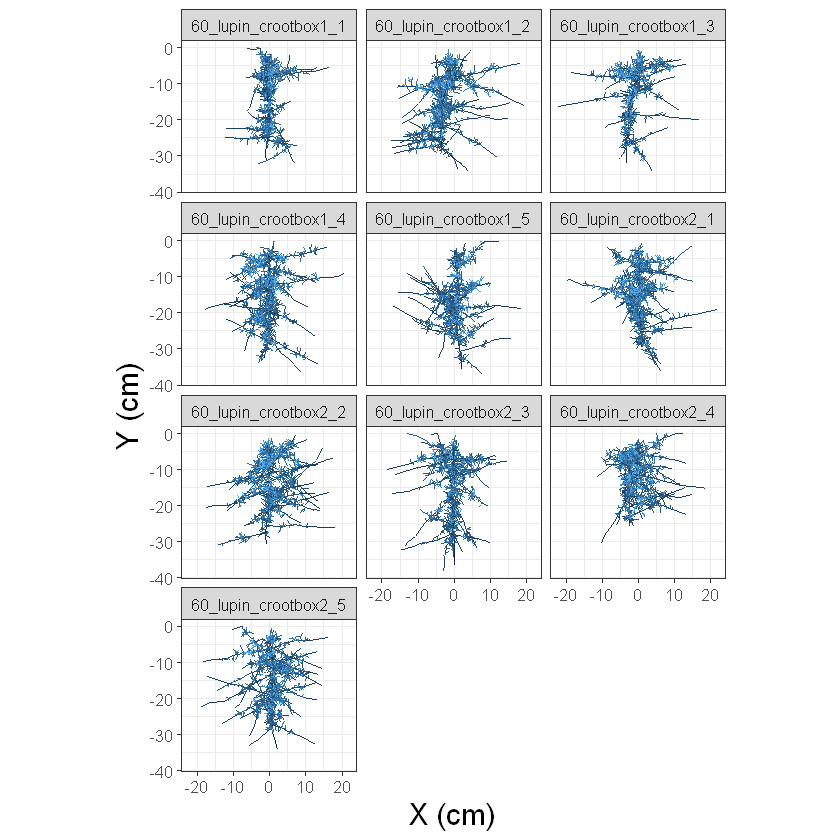

In [21]:
#############################################
#Plot simulated root systems for dicot (mod1)
#############################################

ggplot(transform(mod.dicot, file=factor(file, levels=unique(file))))+
geom_segment(aes(x=x1, y=z1, xend=x2, yend=z2, col=order), size=0.5, alpha=1)+
coord_fixed()+
theme_bw()+
facet_wrap(~file, ncol=3)+
xlab("X (cm)")+
ylab("Y (cm)")+
theme(axis.title=element_text(size=18), text=element_text(size=12), legend.position="none")

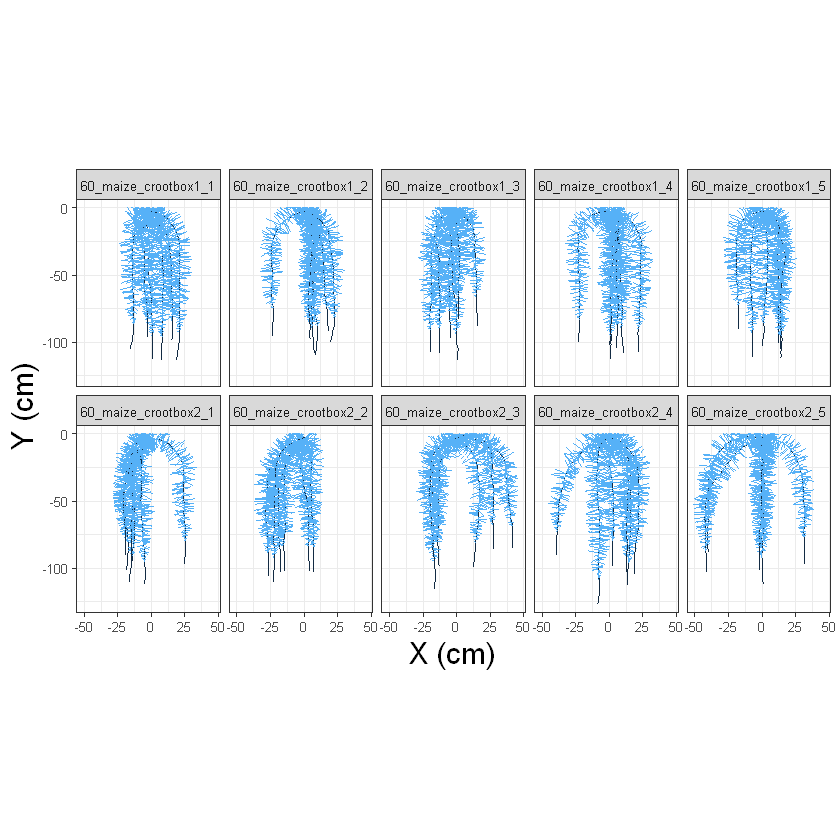

In [23]:
###############################################
#Plot simulated root systems for monocot (mod1)
###############################################

ggplot(transform(mod.monocot, file=factor(file, levels=unique(file))))+
geom_segment(aes(x=x1, y=z1, xend=x2, yend=z2, col=order), size=0.5, alpha=1)+
coord_fixed()+
theme_bw()+
facet_wrap(~file, ncol=5)+
xlab("X (cm)")+
ylab("Y (cm)")+
theme(axis.title=element_text(size=18), text=element_text(size=10), legend.position="none")

## Pipeline 1: _Comparison of traits computed at the root system level between simulated root systems_

### 1.1. Identifying key morphological, architectural, and topological traits explaining differences between simulated root systems

In archiDART, the `architect` function can be used to compute root system traits. For each root system and each observation date, the following parameters will be calculated:

- **TRL**: total root length
- **GRTR**: growth rate of the root system
- **L1R**: first-order root length
- **GR1R**: first-order root growth rate
- **TN1R**: total number of first-order roots
- **TNLR**: total number of lateral roots
- **TLRL**: total lateral root length
- **NxLR**: total number of lateral roots with a branching order equal to x
- **LxLR**: total length of lateral roots with a branching order equal to x
- **MLxLR**: mean length of lateral roots with a branching order equal to x
- **GRxL**: growth rate of roots with a branching order equal to x
- **D2LR**: density of secondary roots on first-order roots
- **Height**: root system height
- **Width**: root system width
- **ConvexhullXY**: area of the convex hull on the XY plane
- **ConvexhullXZ**: area of the convex hull on the XZ plane
- **ConvexhullYZ**: area of the convex hull on the YZ plane
- **Convexhull3D**: volume of the convex hull (for 3D root systems)
- **Magnitude**: the magnitude of the root system (Fitter, 1986, 1987)
- **Altitude**: the altitude of the root system (Fitter, 1986, 1987)
- **ExtPathLength**: the total exterior path length of the root system (Fitter, 1986, 1987)

If diameter values are provided in the RSML files, the following parameters will be calculated for each root system at the last observation date:

- **MDx**: mean diameter of roots with a branching order equal to x
- **MDLR**: mean lateral root diameter
- **Sx**: total surface area of roots with a branching order equal to x
- **Stot**: total root surface area
- **Vx**: total volume of roots with a branching order equal to x
- **Vtot**: the root system volume

The rsmlToTable objects created earlier can directly be used as an input of the `architect` function. Root system traits can be calculated using the following code:

In [26]:
######################################################
#Compute root system traits for simulated root systems
######################################################

#For the dicot
plant.mod.dicot<-architect(inputrsml=mod.dicot, vertical3d=vertical, fitter=TRUE)
filemod<-aggregate(mod.dicot$model, by=list(file=mod.dicot$file, time=mod.dicot$time), unique)
plant.mod.dicot$model<-as.character(filemod$x[match(plant.mod.dicot$FileName,
                                                    paste(filemod$file, "_1", sep=""))])

#For the monocot
plant.mod.monocot<-architect(inputrsml=mod.monocot, vertical3d=vertical, fitter=TRUE)
filemod<-aggregate(mod.monocot$model, by=list(file=mod.monocot$file, time=mod.monocot$time), 
                   unique)
plant.mod.monocot$model<-as.character(filemod$x[match(plant.mod.monocot$FileName,
                                                      paste(filemod$file, "_1", sep=""))])

We will now use **principal component analysis (PCA)** to identify the root system traits explaining the greatest amount of variation between simulated root systems. To do this, we first need to create new objects containing root system traits calculated at the last observation date (60 days). We can do this using the following code:

Warning message in arrows(0, 0, coord.var[v, 1], coord.var[v, 2], length = 0.1, :
"zero-length arrow is of indeterminate angle and so skipped"

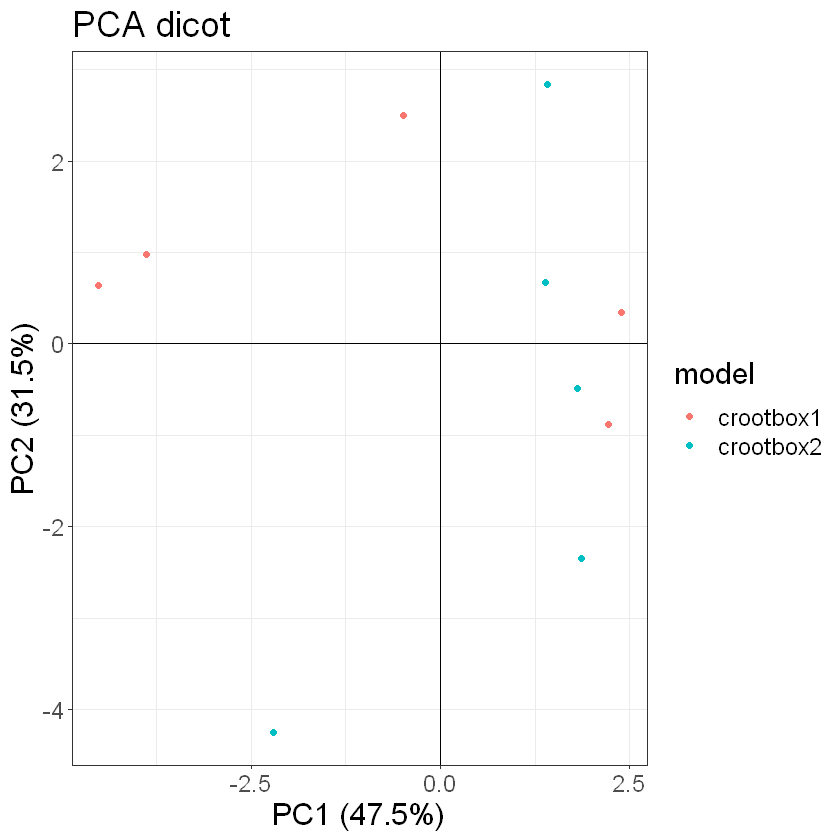

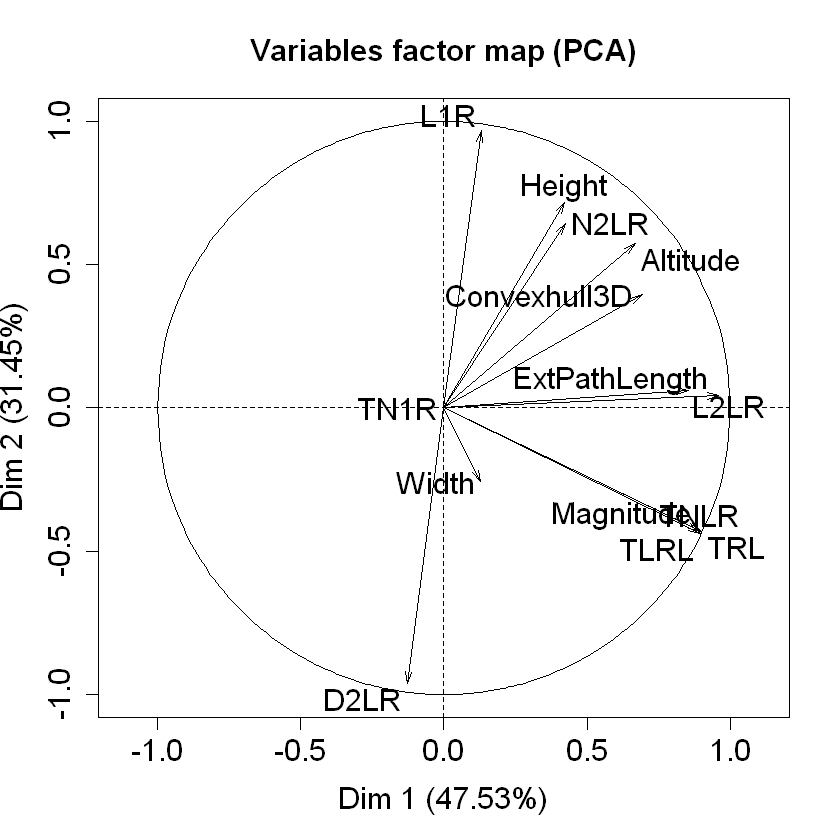

In [27]:
#######################
#Create table for dicot
#######################

datadicot<-plant.mod.dicot[plant.mod.dicot$Time==60,] #Select traits measured at the last observation date

#################
#Do PCA for dicot
#################

#Select variables for PCA

datapca<-datadicot[,c("TRL", "L1R", "TN1R", "TNLR", "TLRL", "N2LR", "L2LR", "D2LR", "Height", 
                      "Width", "Convexhull3D",
                      "Magnitude", "Altitude", "ExtPathLength", "model")]

#PCA dicot
pca<-PCA(datapca, scale.unit=TRUE, ncp=3, quali.sup=which(colnames(datapca)=="model"), 
         graph=FALSE)
indpca<-as.data.frame(pca$ind$coord)
indpca<-as.data.frame(lapply(indpca, function(x) as.numeric(as.character(x))))
indpca$model<-datadicot$model

#Plot PCA dicot
ggplot(indpca)+
geom_point(aes(Dim.1, Dim.2, colour=model))+
xlab(paste("PC1 (", round(pca$eig[1,2], 1), "%)", sep=""))+
ylab(paste("PC2 (", round(pca$eig[2,2], 1), "%)", sep=""))+
ggtitle("PCA dicot")+
geom_hline(yintercept=0)+
geom_vline(xintercept=0)+
theme_bw()+
theme(axis.title=element_text(size=18), text=element_text(size=18))

#Plot correlation circle
par(ps = 18, cex = 1, cex.main = 1)
plot(pca, choix="var")

Warning message in arrows(0, 0, coord.var[v, 1], coord.var[v, 2], length = 0.1, :
"zero-length arrow is of indeterminate angle and so skipped"

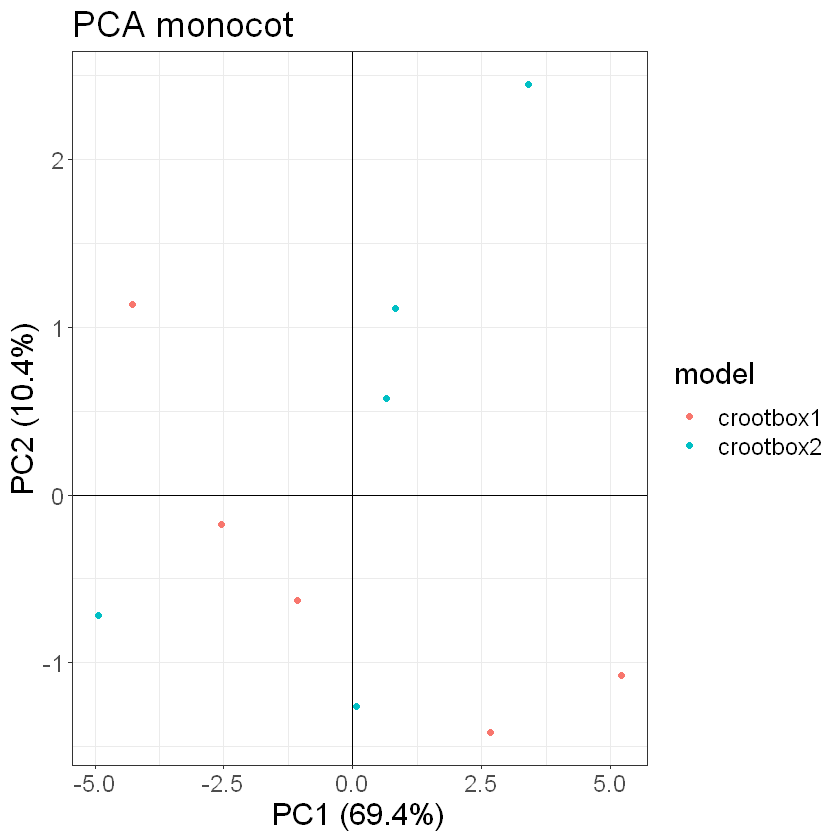

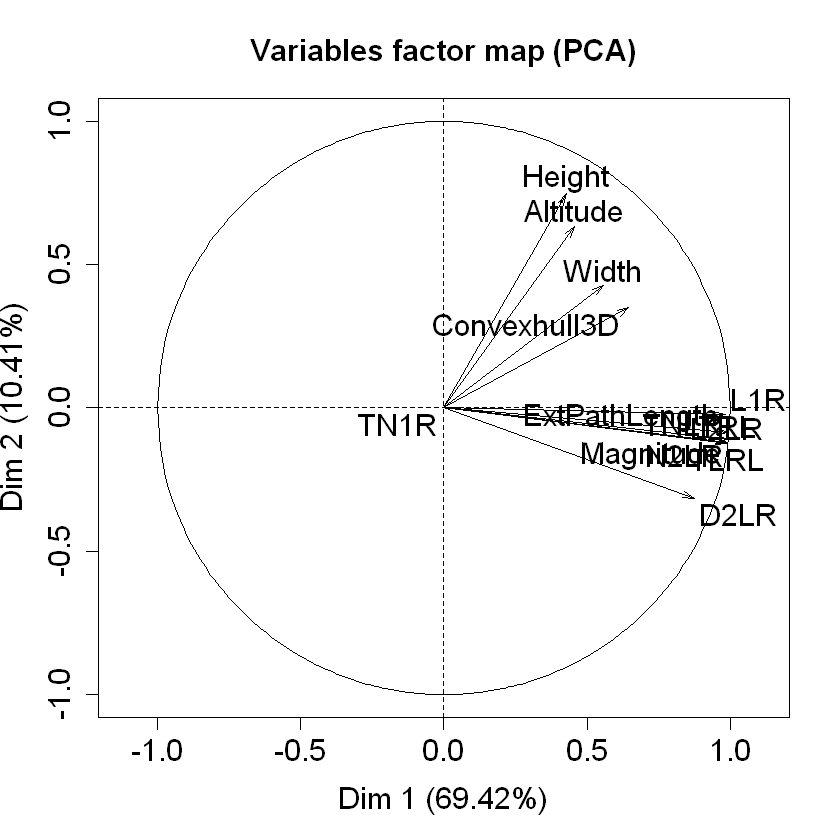

In [28]:
#########################
#Create table for monocot
#########################

datamonocot<-plant.mod.monocot[plant.mod.monocot$Time==60,] #Select traits measured at the last observation date

####################
#Do PCA for monocot
####################

#Select variables for PCA
datapca<-datamonocot[,c("TRL", "L1R", "TN1R", "TNLR", "TLRL", "N2LR", "L2LR", "D2LR", "Height", "Width", "Convexhull3D",
                        "Magnitude", "Altitude", "ExtPathLength", "model")]

#PCA monocot
pca<-PCA(datapca, scale.unit=TRUE, ncp=3, quali.sup=which(colnames(datapca)=="model"), graph=FALSE)
indpca<-as.data.frame(pca$ind$coord)
indpca<-as.data.frame(lapply(indpca, function(x) as.numeric(as.character(x))))
indpca$model<-datamonocot$model

#Plot PCA monocot
ggplot(indpca)+
geom_point(aes(Dim.1, Dim.2, colour=model))+
xlab(paste("PC1 (", round(pca$eig[1,2], 1), "%)", sep=""))+
ylab(paste("PC2 (", round(pca$eig[2,2], 1), "%)", sep=""))+
ggtitle("PCA monocot")+
geom_hline(yintercept=0)+
geom_vline(xintercept=0)+
theme_bw()+
theme(axis.title=element_text(size=18), text=element_text(size=18))

#Plot correlation circle
par(ps = 18, cex = 1, cex.main = 1)
plot(pca, choix="var")

### 1.2. Looking at when simulated and reference root systems start to diverge/converge with regard to the key root system traits identified in step 1 and how large these differences are

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


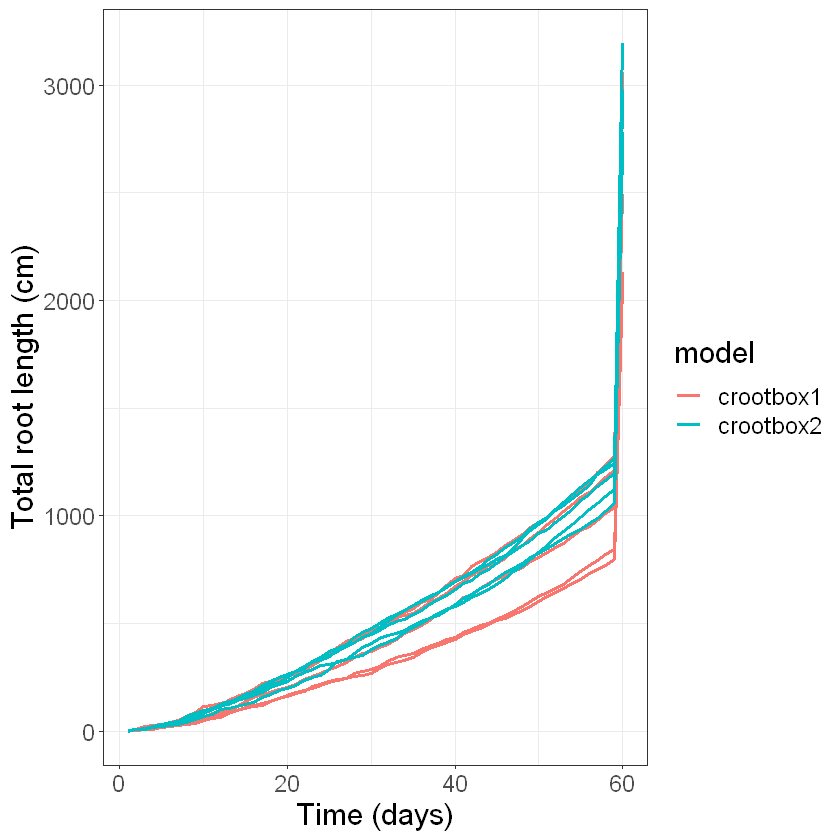

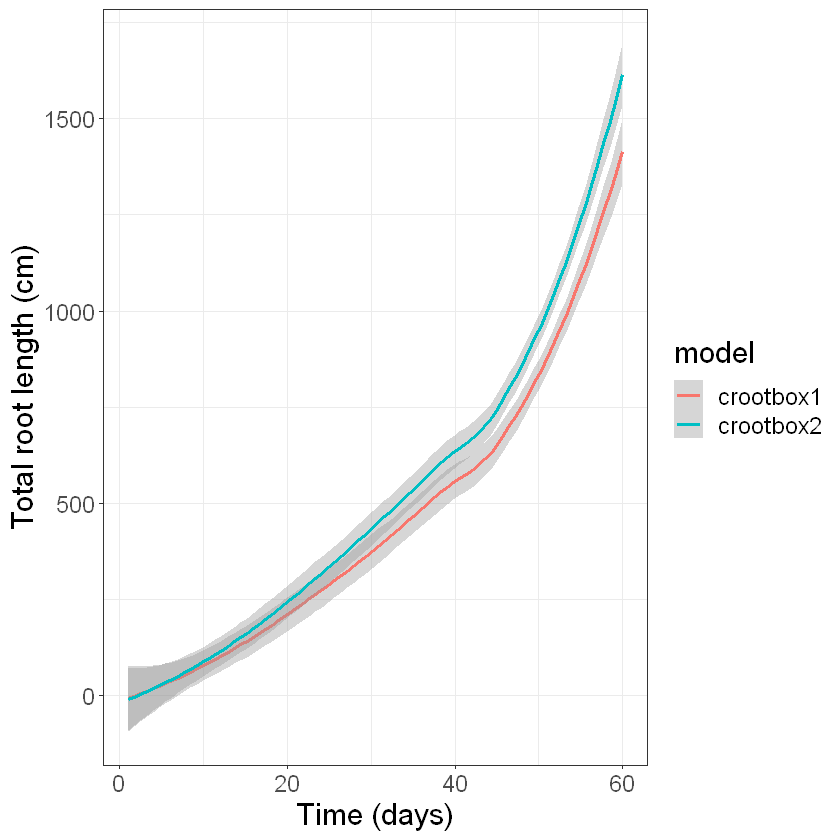

In [29]:
#####################
#Plot trait for dicot
#####################

#Plot results for all simulations
ggplot(plant.mod.dicot)+
geom_line(aes(x=Time, y=TRL, colour=model, group=paste(FileName, model)), size=1)+
xlab("Time (days)")+
ylab("Total root length (cm)")+
theme_bw()+
theme(axis.title=element_text(size=18), text=element_text(size=18))

#Plot average per simulation
ggplot(plant.mod.dicot)+
stat_smooth(aes(x=Time, y=TRL, colour=model), size=1)+
xlab("Time (days)")+
ylab("Total root length (cm)")+
theme_bw()+
theme(axis.title=element_text(size=18), text=element_text(size=18))

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


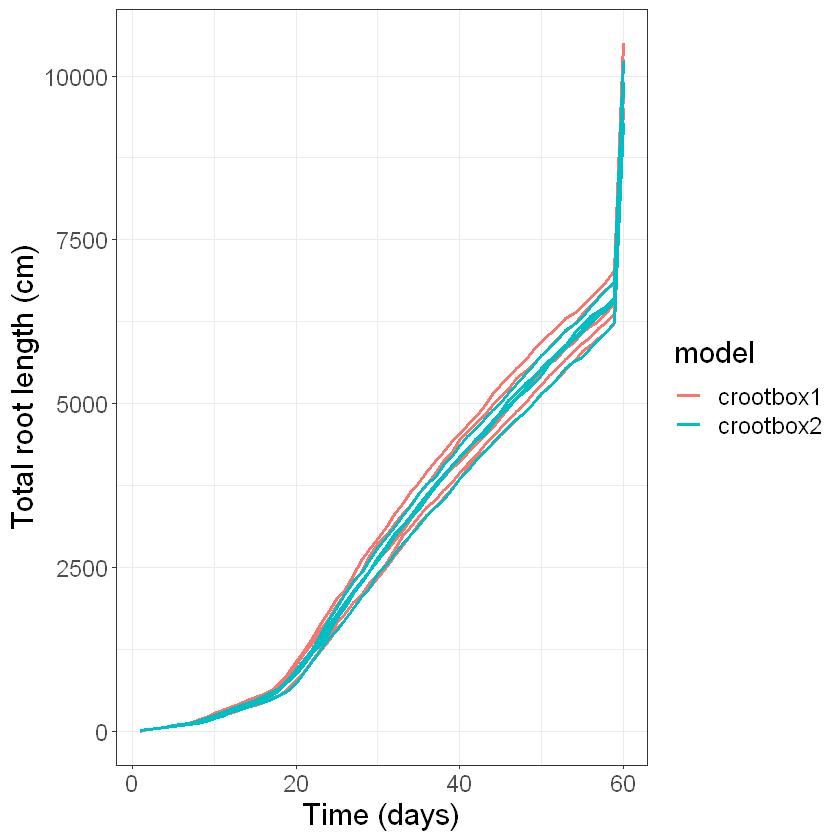

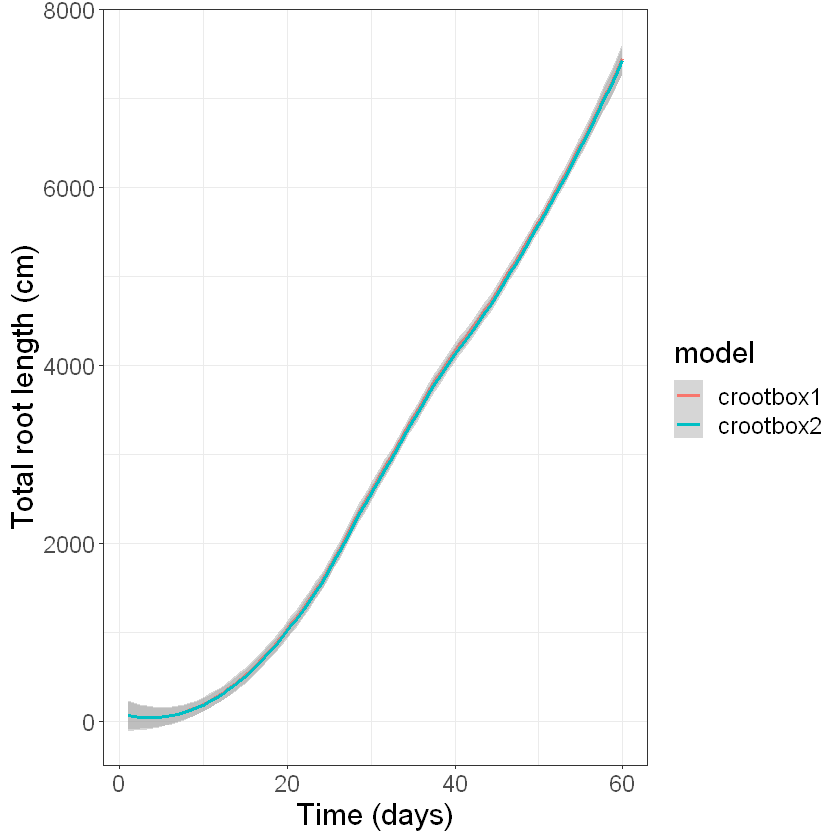

In [30]:
########################
#Plot trait for monocot
########################

#Plot results for all simulations
ggplot(plant.mod.monocot)+
geom_line(aes(x=Time, y=TRL, colour=model, group=paste(FileName, model)), size=1)+
xlab("Time (days)")+
ylab("Total root length (cm)")+
theme_bw()+
theme(axis.title=element_text(size=18), text=element_text(size=18))

#Plot average per simulation
ggplot(plant.mod.monocot)+
stat_smooth(aes(x=Time, y=TRL, colour=model), size=1)+
xlab("Time (days)")+
ylab("Total root length (cm)")+
theme_bw()+
theme(axis.title=element_text(size=18), text=element_text(size=18))

### 1.3. Assessing the degree of dissimilarity between simulated root systems using dissimilarity metrics

The deviation between model predictions will be quantified using performance measures listed in Table 1 of [Janssen and Heuberger (1995)](https://www.sciencedirect.com/science/article/pii/0304380095000849).

## Pipeline 2: _Comparing dissimilarities in architecture between simulated root systems using persistent homology analysis_

### 2.1. Computing a persistence barcode for each simulated root system using a geodesic distance function

Persistent homology is a mathematical framework allowing the topological analysis of branching structures, such as shoot and root systems. Recently, a new data analysis pipeline was implemented in archiDART to analyse root system architectures using persistent homology. More information can be found in [Li et al (2017)](https://onlinelibrary.wiley.com/doi/abs/10.3732/ajb.1700046) and [Delory et al (2018)](https://f1000research.com/articles/7-22/v1).

The main output of a persistent homology analysis is a persistence barcode recording the birth (apparition of a new connected component) and death (fusion of two connected components) of each branch when a distance function traverses the branching structure. For a given mathematical function, one persistence barcode can be computed for each simulated root system. Look at Figure 1 and interactive Figure 3 [in this paper](https://f1000research.com/articles/7-22/v1) for a more accurate description of a persistence barcode. Barcodes can be computed using the following code:

In [31]:
#######################################
#Compute persistence barcodes for dicot
#######################################

ph.dicot<-perhomology(mod.dicot, show.progress=TRUE)

#########################################
#Compute persistence barcodes for monocot
#########################################

ph.monocot<-perhomology(mod.monocot, show.progress=TRUE)

  |======================================================================| 100%

### 2.2. Computing dissimilarities between persistence barcodes using a bottleneck distance

To compare persistence barcodes against each other, a pairwise distance matrix is needed and the bottleneck distance is one possible option. The **bottleneck distance** is considered as a robust dissimilarity metric between two persistence barcodes, and its interpretation is quite straightforward: the greater the distance between two persistence barcodes, the greater will be the dissimilarity between them. Such pairwise bottleneck distance matrix can be calculated with the `bottleneckdist` function of the archiDART package. This function only requires a perhomology object as an input. It has to be noted that the computation time required to compute a bottleneck distance matrix is highly dependent on the number and complexity of root systems being compared.

In [17]:
#NOT RUN BECAUSE TIME CONSUMING

#############################################
#Compute bottleneck distance matrix for dicot
#############################################

#distance.dicot<-bottleneckdist(ph.dicot, show.progress=TRUE)

###############################################
#Compute bottleneck distance matrix for monocot
###############################################

#distance.monocot<-bottleneckdist(ph.monocot, show.progress=TRUE)

### 2.3. Visualizing dissimilarities between root systems using multidimensional scaling

In [18]:
###################################
#Multidimensional scaling for dicot
###################################

#k is the number of dimensions
#k<-3
#mds.dicot<-cmdscale(distance.dicot, k=k, eig=TRUE, add=TRUE)

#Evaluate quality of representation using a Shepard plot
#realdist<-as.vector(as.dist(distance.dicot))
#confdist<-as.vector(dist(mds.dicot$points))
#par(ps=18, cex=1, cex.main=1)
#plot(realdist, confdist, xlab="Real distances", ylab="Distances in configuration", pch=16, main="Shepard plot", las=1)
#abline(a=0, b=1, col="red", lwd=2)

#Plot MDS for dicot
#model<-datadicot[datadicot$Time==60, "model"]
#datamds<-data.frame(mds.dicot$points, model=model)
#colnames(datamds)<-c(paste(rep("MDS", k), c(1:k), sep=""), "model")

#ggplot(datamds)+
#geom_point(aes(MDS1, MDS2, colour=model))+
#geom_hline(yintercept=0)+
#geom_vline(xintercept=0)+
#ggtitle("Metric multidimensional scaling")+
#xlab("MDS1")+
#ylab("MDS2")+
#theme_bw()+
#theme(axis.title=element_text(size=18), text=element_text(size=18))

In [19]:
#####################################
#Multidimensional scaling for monocot
#####################################

#k is the number of dimensions
#k<-3
#mds.monocot<-cmdscale(distance.monocot, k=k, eig=TRUE, add=TRUE)

#Evaluate quality of representation using a Shepard plot
#realdist<-as.vector(as.dist(distance.monocot))
#confdist<-as.vector(dist(mds.monocot$points))
#par(ps=18, cex=1, cex.main=1)
#plot(realdist, confdist, xlab="Real distances", ylab="Distances in configuration", pch=16, main="Shepard plot", las=1)
#abline(a=0, b=1, col="red", lwd=2)
#
#Plot MDS for dicot
#model<-datamonocot[datamonocot$Time==60, "model"]
#datamds<-data.frame(mds.monocot$points, model=model)
#colnames(datamds)<-c(paste(rep("MDS", k), c(1:k), sep=""), "model")

#ggplot(datamds)+
#geom_point(aes(MDS1, MDS2, colour=model))+
#geom_hline(yintercept=0)+
#geom_vline(xintercept=0)+
#ggtitle("Metric multidimensional scaling")+
#xlab("MDS1")+
#ylab("MDS2")+
#theme_bw()+
#theme(axis.title=element_text(size=18), text=element_text(size=18))

### 2.4. Testing specific hypotheses

In [20]:
################
#PERMANOVA dicot
################

#permanova.dicot<-adonis(as.dist(distance.dicot)~model, data=data.frame(file=rownames(distance.dicot), model=model),
                        #permutations = 10000, sqrt.dist=TRUE)
#permanova.dicot

#Chech PERMANOVA assumption (multivariate homogeneity of group dispersions)
#bd<-betadisper(as.dist(distance.dicot), model)
#par(ps=18, cex=1, cex.main=1)
#boxplot(bd)
#permutest(bd, permutations=1000)

In [21]:
##################
#PERMANOVA monocot
##################

#permanova.monocot<-adonis(as.dist(distance.monocot)~model, data=data.frame(file=rownames(distance.monocot), model=model), 
                          #permutations = 10000, sqrt.dist=TRUE)
#permanova.monocot

#Chech PERMANOVA assumption (multivariate homogeneity of group dispersions)
#bd<-betadisper(as.dist(distance.monocot), model)
#par(ps=18, cex=1, cex.main=1)
#boxplot(bd)
#permutest(bd, permutations=1000)

## Pipeline 3: _Comparing the vertical root distribution between simulated root systems using a modelisation approach_

For each simulated root system, the vertical root distribution is analysed using the modelisation approach described in [Oram et al (2018)](https://besjournals.onlinelibrary.wiley.com/doi/full/10.1111/1365-2745.12877). Briefly, the vertical root distribution of each root system is modeled using the following asymptotic equation:

\begin{equation*}
Y = 1-\beta^d
\end{equation*}

where *Y* is the cumulative proportion of the total root length found between the soil surface and depth *d* (cm). *Y* has a value comprised between 0 and 1. $\beta$ is a model parameter describing the decline of proportional root length over depth. High values of $\beta$ means that a greater proportion of roots are located in deeper soil layers, while lower values of $\beta$ are associated with root systems having a greater proportion of roots close to the soil surface.

In this pipeline, we will first estimate the value of $\beta$ for each root system. Then, the average $\beta$ value will be compared between RSA models. If different models simulate root systems with similar vertical root distributions, we expect these models to have similar average $\beta$ values.

In [32]:
#################################
#Vertical root distribution dicot
#################################

rld.dicot<-data.frame()
betas.dicot<-data.frame()

for (model in unique(mod.dicot$model)){
    
    for (file in unique(mod.dicot$file[mod.dicot$model==model])){
        
        sub<-mod.dicot[mod.dicot$model==model & mod.dicot$file==file,]
        sub<-sub[order(sub$z2, decreasing=TRUE),]
        sub$cumulprop<-cumsum(sub$length)/sum(sub$length)
        mod<-nls(cumulprop~1-beta^z2, sub, start=list(beta=1))
        betas.dicot<-rbind(betas.dicot, data.frame(model=model, file=file, beta=coef(mod)))
        rld.dicot<-rbind(rld.dicot, sub[,c("model", "file", "z2", "cumulprop")])}}

`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


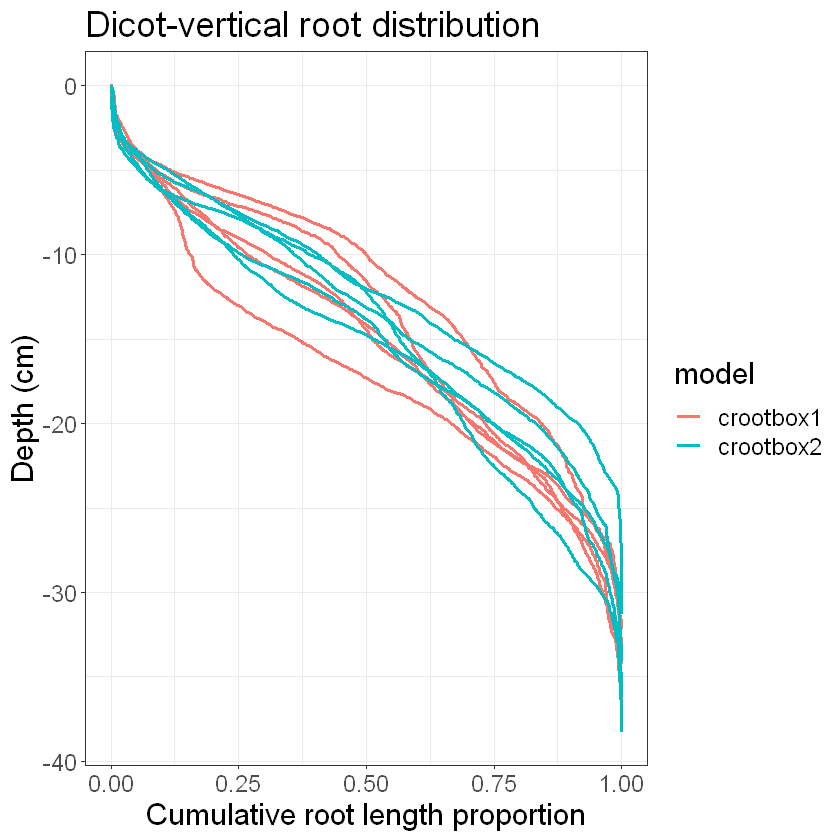

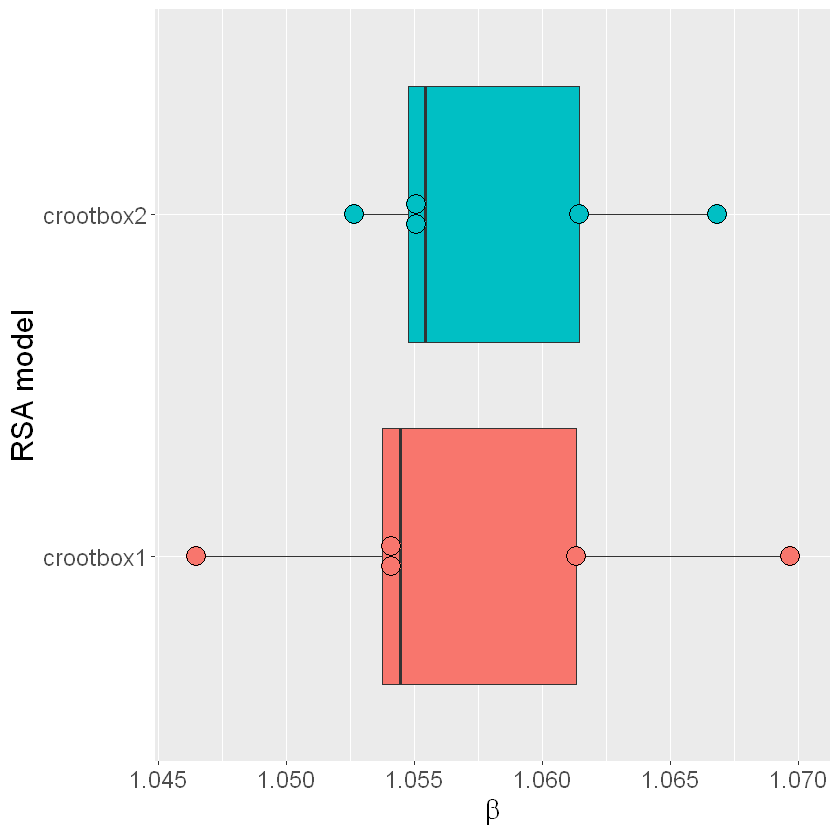

In [34]:
#######################################
#Plot vertical root distribution dicot
#######################################

ggplot(rld.dicot) +
geom_line(aes(x = z2, y = cumulprop, colour=model, group=paste(model, file, sep="-")), size=1)+ 
coord_flip() +
xlab("Depth (cm)") +
ylab("Cumulative root length proportion")+
ggtitle("Dicot-vertical root distribution")+
theme_bw()+
theme(axis.title=element_text(size=18), text=element_text(size=18))

ggplot(betas.dicot, aes(x=model, y=beta, fill=model))+
geom_boxplot()+
coord_flip()+
geom_dotplot(binaxis="y", stackdir="center", dotsize=1)+
ylab(expression(beta))+
xlab("RSA model")+
theme(axis.title=element_text(size=18), text=element_text(size=18), legend.position="none")

In [35]:
####################################
#Vertical root distribution monocot
####################################

rld.monocot<-data.frame()
betas.monocot<-data.frame()

for (model in unique(mod.monocot$model)){
    
    for (file in unique(mod.monocot$file[mod.monocot$model==model])){
        
        sub<-mod.monocot[mod.monocot$model==model & mod.monocot$file==file,]
        sub<-sub[order(sub$z2, decreasing=TRUE),]
        sub$cumulprop<-cumsum(sub$length)/sum(sub$length)
        mod<-nls(cumulprop~1-beta^z2, sub, start=list(beta=1))
        betas.monocot<-rbind(betas.monocot, data.frame(model=model, file=file, beta=coef(mod)))
        rld.monocot<-rbind(rld.monocot, sub[,c("model", "file", "z2", "cumulprop")])}}

`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.


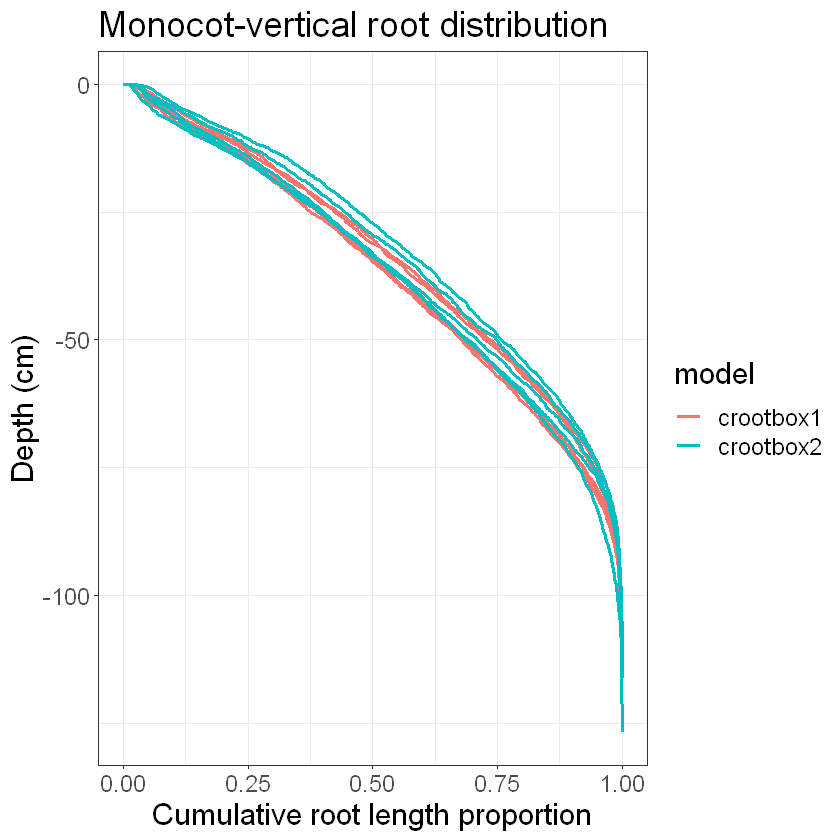

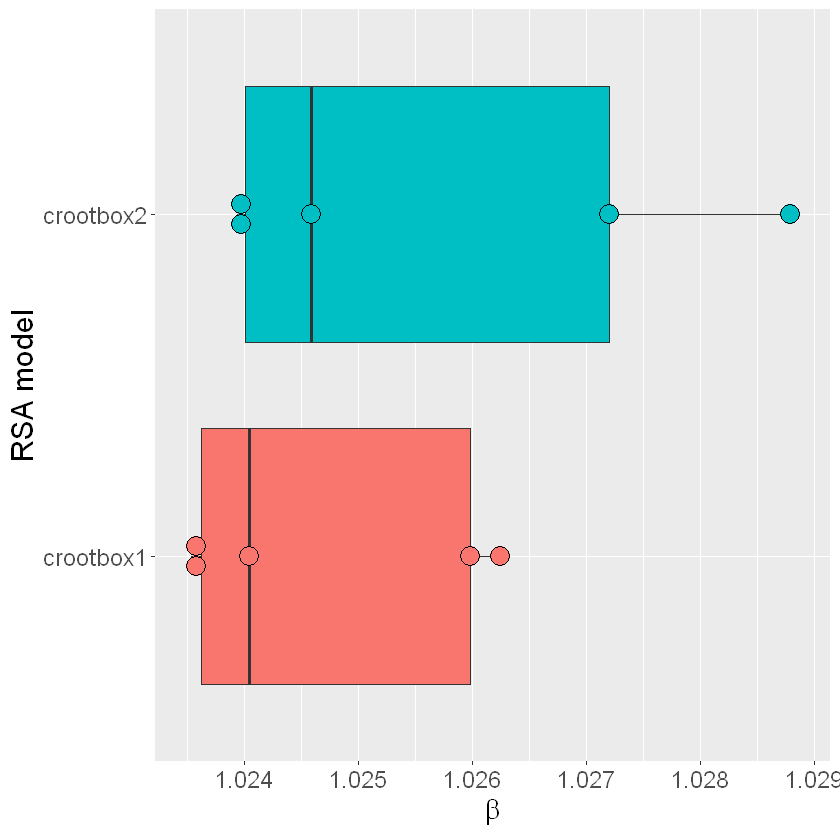

In [36]:
#########################################
#Plot vertical root distribution monocot
#########################################

ggplot(rld.monocot) +
geom_line(aes(x = z2, y = cumulprop, colour=model, group=paste(model, file, sep="-")), size=1)+ 
coord_flip() +
xlab("Depth (cm)") +
ylab("Cumulative root length proportion")+
ggtitle("Monocot-vertical root distribution")+
theme_bw()+
theme(axis.title=element_text(size=18), text=element_text(size=18))

ggplot(betas.monocot, aes(x=model, y=beta, fill=model))+
geom_boxplot()+
coord_flip()+
geom_dotplot(binaxis="y", stackdir="center", dotsize=1)+
ylab(expression(beta))+
xlab("RSA model")+
theme(axis.title=element_text(size=18), text=element_text(size=18), legend.position="none")

## References

Delory, B. M., Baudson, C., Brostaux, Y., Lobet, G., du Jardin, P., Pagès, L., and Delaplace,P. (2016). [archiDART: an R package for the automated computation of plant root architectural traits](https://link.springer.com/article/10.1007/s11104-015-2673-4). _Plant and Soil_, 398(1):351–365.

Delory, B. B. M., Li, M., Topp, C. C. N., and Lobet, G. (2018). [archiDART v3.0: A new data analysis pipeline allowing the topological analysis of plant root systems](https://f1000research.com/articles/7-22/v1). _F1000Research_, 7:22.

Fitter, A.H. (1986). [The topology and geometry of plant root systems: influence of watering rate on root system topology in _Trifolium pratense_](https://academic.oup.com/aob/article/58/1/91/174778). _Annals of Botany_, 58(1):91–101.

Fitter, A.H. (1987). [An architectural approach to the comparative ecology of plant root systems](https://nph.onlinelibrary.wiley.com/doi/abs/10.1111/j.1469-8137.1987.tb04683.x). _New Phytologist_, 106(s1):61–77.

Hund, A., Trachsel, S., and Stamp, P. (2009). [Growth of axile and lateral roots of maize: Idevelopment of a phenotying platform](https://link.springer.com/article/10.1007/s11104-009-9984-2). _Plant and Soil_, 325(1):335–349.

Janssen, P.H.M. and Heuberger, P.S.C. (1995). [Calibration of process-oriented models](https://www.sciencedirect.com/science/article/pii/0304380095000849). _Ecological Modelling_, 83:55-66.

Lobet, G., Pagès, L., and Draye, X. (2011). [A novel image-analysis toolbox enabling quantitative analysis of root system architecture](http://www.plantphysiol.org/content/157/1/29). _Plant Physiology_, 157:29–39.

Lobet, G., Pound, M. P., Diener, J., Pradal, C., Draye, X., Godin, C., Javaux, M., Leitner, D.,Meunier, F., Nacry, P., Pridmore, T. P., and Schnepf, A. (2015). [Root System Markup Language: toward an unified root architecture description language](http://www.plantphysiol.org/content/167/3/617). _Plant Physiology_, 167:617–627.

Oram, N.J., Ravenek, J.M., Barry, K.E., Weigelt, A., Chen, H., Gessler, A., Gockele, A., de Kroon, H., van der Paauw, J.W., Scherer-Lorenzen, M., Smit-Tiekstra, A., van Ruijven, J., and Mommer L. (2018). [Below-ground complementarity effects in a grassland biodiversity experiment are related to deep-rooting species](https://besjournals.onlinelibrary.wiley.com/doi/full/10.1111/1365-2745.12877). _Journal of Ecology_, 106, 265-277.